# TUTORIAL: Speech to text - Speaker diarization and timestamped transcript

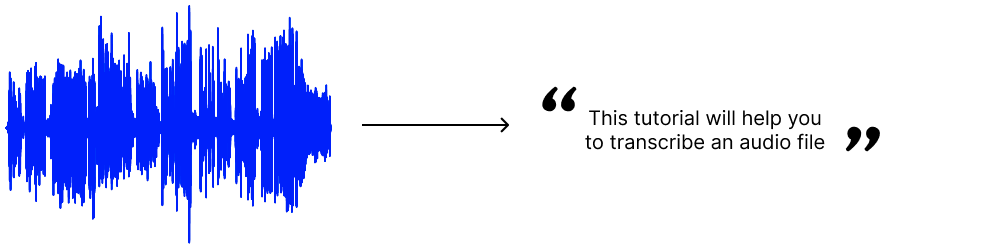

## Introduction

This notebook is the second of a series of tutorials. We strongly recommend you to **read the first episode [Speech to text - Basics]** before doing this one, since we will use functions defined and explained in the previous episode. 

## Objective

The different steps of this second tutorial are as follow:

- Set up environment
- Speaker diarization (Differentiate speakers)
- Create subtitles for videos, movies, ... (.srt file)

## Going further

**Next tutorials** will show you how to:

- Compare models and choose the best one
- Build a complete Streamlit application to make your code interactive

## Step 1 - Set up environment

*This notebook has been created on **AI Notebooks** with the `conda-py39-cuda11.2-v22-4` image*

### A - Install and import dependencies

As the first step, let's set up the structure of our project. Several librairies need to be installed and imported. 

In [ ]:
!pip install -r requirements.txt

In [2]:
# Manipulate sound
import audioread
from IPython.display import Audio
import librosa
from pydub import AudioSegment, silence

# Load models & metrics to evaluate results
from transformers import Wav2Vec2Tokenizer, Wav2Vec2ForCTC 
import torch
from pyannote.audio import Pipeline

# Others (Text & time process, system navigation)
import pandas as pd
from datetime import timedelta
import os

### B - Create a folder to store the sounds we transcribe

In [3]:
# folder's path
dir_path = "/workspace/audio_chunks" 

# if folder does not exist, we create it
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

### C - Import code from previous tutorial

> #### All this code has been explained in the [first tutorial](https://github.com/ovh/ai-training-examples/blob/main/notebooks/natural-language-processing/speech-to-text/conda/basics/speech-to-text-basics.ipynb) in which we studied the basics. Its usefulness will therefore not be re-explained here.

In [ ]:
# Load speech to text model
stt_tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
stt_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

> ⚠️ Messages in red as above may appear throughout the execution of the code, don't worry!

In [5]:
def transcribe_audio_part(filename, stt_model, stt_tokenizer, myaudio, sub_start, sub_end, index):
    """
    Transcribe an audio between a sub_start and a sub_end value (s)
    :param filename: name of the audio file
    :param stt_model: Wav2Vec2 Model (Speech to text model)
    :param stt_tokenizer: Wav2Vec2’s Tokenizer (Speech to text model's tokenizer)
    :param myaudio: AudioSegment file
    :param sub_start: start value (s) of the considered audio part to transcribe
    :param sub_end: end value (s) of the considered audio part to transcribe
    :param index: audio file counter

    :return: transcript of the considered audio (only in uppercases, so we add lower() to make the reading easier)
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    try:
        with torch.no_grad():
            new_audio = myaudio[sub_start:sub_end]  # Works in milliseconds
            path = "/workspace/audio_chunks/" + filename[:-3] + str(index) + ".mp3"
            new_audio.export(path)  # Exports to a mp3 file in the current path.
            
            # Load audio file with librosa, set sound rate to 16000 Hz because the model we use was trained on 16000 Hz data.
            input_audio, _ = librosa.load(path, sr=16000)

            # return PyTorch torch.Tensor instead of a list of python integers thanks to return_tensors = ‘pt’
            input_values = stt_tokenizer(input_audio,
                                         return_tensors="pt").to(device).input_values  
            
            # Get logits from the data structure containing all the information returned by the model and get our prediction
            logits = stt_model.to(device)(input_values).logits
            prediction = torch.argmax(logits, dim=-1)

            # Decode & lower our string (model's output is only uppercase)
            transcript = stt_tokenizer.batch_decode(prediction)[0]
            return transcript.lower()

    except audioread.NoBackendError:
        # Means we have a chunk with a [value1 : value2] case with value1>value2
        print("Sorry, seems we have a problem on our side. Please change start & end values.")
        
        # Stop 
        exit()

In [6]:
def detect_silences(audio):
    # Get Decibels (dB) so silences detection depends on the audio instead of a fixed value
    dbfs = audio.dBFS
    
    # Get silences timestamps > 750ms 
    silence_list = silence.detect_silence(audio, min_silence_len=750, silence_thresh=dbfs-14)
    return silence_list

In [7]:
def get_middle_values(silence_list):
    # Replace timestamps by their middle value
    new_silence_list=[]
    for timestamp in silence_list:
        new_silence_list.append(timestamp[0]+(timestamp[1]-timestamp[0])/2)
    return new_silence_list

In [8]:
def silences_distribution(silence_list, min_space, max_space, start, end, srt_token=False):
    """
    We keep each silence value if it is sufficiently distant from its neighboring values, without being too much
    :param silence_list: List with silences intervals
    :param min_space: Minimum temporal distance between two silences
    :param max_space: Maximum temporal distance between two silences
    :param start: int value (seconds)
    :param end: int value (seconds)
    :param srt_token: Enable/Disable generate srt file (choice fixed by user)
    :return: list with equally distributed silences
    """
    # If starts != 0, we need to adjust end value since silence detection is performed on the cropped audio (and not on the original audio)

    # Shift the end according to the start value
    end -= start
    start = 0
    end *= 1000

    # Step 1 - Adding start value
    newsilence = [start]

    # Step 2 - Create a regular distribution between start and the first element of silence_list to don't have a gap > max_space and run out of memory
    # example newsilence = [0] and silence_list starts with 100000 => It will create a massive gap [0, 100000]

    if silence_list[0] - max_space > newsilence[0]:
        for i in range(int(newsilence[0]), int(silence_list[0]), max_space):  # int bc float can't be in a range loop
            value = i + max_space
            if value < silence_list[0]:
                newsilence.append(value)

    # Step 3 - Create a regular distribution until the last value of the silence_list
    min_desired_value = newsilence[-1]
    max_desired_value = newsilence[-1]
    nb_values = len(silence_list)

    while nb_values != 0:
        max_desired_value += max_space

        # Get a window of the values greater than min_desired_value and lower than max_desired_value
        silence_window = list(filter(lambda x: min_desired_value < x <= max_desired_value, silence_list))

        if silence_window != []:
            # Get the nearest value we can to min_desired_value or max_desired_value depending on srt_token
            if srt_token:
                nearest_value = min(silence_window, key=lambda x: abs(x - min_desired_value))
                nb_values -= silence_window.index(nearest_value) + 1  # (index begins at 0, so we add 1)
            else:
                nearest_value = min(silence_window, key=lambda x: abs(x - max_desired_value))
                # Max value index = len of the list
                nb_values -= len(silence_window)

            # Append the nearest value to our list
            newsilence.append(nearest_value)

        # If silence_window is empty we add the max_space value to the last one to create an automatic cut and avoid multiple audio cutting
        else:
            newsilence.append(newsilence[-1] + max_space)

        min_desired_value = newsilence[-1]
        max_desired_value = newsilence[-1]

    # Step 4 - Add the final value (end)

    if end - newsilence[-1] > min_space:
        # Gap > Min Space
        if end - newsilence[-1] < max_space:
            newsilence.append(end)
        else:
            # Gap too important between the last list value and the end value
            # We need to create automatic max_space cut till the end
            newsilence = generate_regular_split_till_end(newsilence, end, min_space, max_space)
    else:
        # Gap < Min Space <=> Final value and last value of new silence are too close, need to merge
        if len(newsilence) >= 2:
            if end - newsilence[-2] <= max_space:
                # Replace if gap is not too important
                newsilence[-1] = end
            else:
                newsilence.append(end)

        else:
            if end - newsilence[-1] <= max_space:
                # Replace if gap is not too important
                newsilence[-1] = end
            else:
                newsilence.append(end)

    return newsilence

In [9]:
def generate_regular_split_till_end(time_list, end, min_space, max_space):
    """
    Add automatic "time cuts" to time_list till end value depending on min_space and max_space value
    :param time_list: silence time list
    :param end: int value (s)
    :param min_space: Minimum temporal distance between two silences
    :param max_space: Maximum temporal distance between two silences
    :return: list with automatic time cuts
    """
    # In range Loop can't handle float values so we convert to int
    int_last_value = int(time_list[-1])
    int_end = int(end)
    
    # Add maxspace to the last list value and add this value to the list
    for i in range(int_last_value, int_end, max_space):
        value = i + max_space
        if value < end:
            time_list.append(value)

    # Fix last automatic cut
    # If small gap (ex: 395 000, with end = 400 000)
    if end - time_list[-1] < min_space:
        time_list[-1] = end
    else:
        # If important gap (ex: 311 000 then 356 000, with end = 400 000, can't replace and then have 311k to 400k)
        time_list.append(end)
    return time_list

# Step 2 - Differentiate speakers

Now that you know the basics of speech transcription, you might be interested in the diarization. It consists in partitioning the transcript among the several persons who speak in a conversation and then improves the readability of a speech transcription.

Indeed, you will get a transcript that looks like this: 
    
> **Client1**: What is AI Notebooks?
>    
> **Manager**: This product is a convenient, easy to use and cost effective way to adress all your data science projects. 
>
> **Client2**: Will our projects be secured if they are stored in your Cloud?
>
> **Manager**: It is one of our main goals in the company. As AI Notebooks is built on OVH Public Cloud, the product benefits from the A grade which ensures the security of your datas and a respect of your privacy.
>
> **Client2**: Perfect, thank you!

### A - Load model

This task is hard to perform, espacially when people are speaking at the same time. But it can be done thanks to pyannote library. You can load the diarization model with the following pipeline :

In [ ]:
dia_pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization")

### B - Load an audio file

Study the audio file from first tutorial would not be interesting here as there is only one speaker in it. Try to select an audio file where several persons are speaking. This file can either be a local one, or extracted from a YouTube video like we have seen in the first tutorial.

Keep in mind that the longer your audio is, the longer the result will.

To illustrate this, I will use an audio from the [AMI Dataset](https://groups.inf.ed.ac.uk/ami/corpus/). Recordings from this dataset have been released publicly under the [Creative Commons Attribution 4.0 International Licence (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/). 

In [11]:
# Get an audio file where there are several speakers 
filename = "IB4011.Mix-Headset.mp3"

# Create an audio segment from it
conversation_audio = AudioSegment.from_file("sounds/" + filename)

### C - Convert audio file format

Once we have the diarization model loaded and our audio file, we need to **verify its format**. Indeed, pyannote's diarization **only accepts today** `.wav` format. If you send a `.mp3` or `.mp4` in the diarization algorithm, you will get errors.

But do not worry, this audio format convertion can be easily done with pydub as follow: 

In [12]:
def convert_file_to_wav(aud_seg, filename):
    """
    Convert a mp3/mp4 in a wav format
    Needs to be modified if you want to convert a format which contains less or more than 3 letters

    :param aud_seg: pydub.AudioSegment
    :param filename: name of the file
    :return: name of the converted file
    """
    filename =  filename[:-3] + "wav" #folder
    file_path = "sounds/" + filename
    aud_seg.export(file_path, format="wav")

    newaudio = AudioSegment.from_file(file_path)

    return newaudio, filename

In [13]:
# Convert mp3/mp4 to wav (Differentiate speakers mode only accepts wav files)
if filename.endswith((".mp3", ".mp4")):
    conversation_audio, filename = convert_file_to_wav(conversation_audio, filename)

### D - Get diarization
Once the audio is converted, we can send the `.wav` audio to pyannote's diarization

In [14]:
def get_diarization(dia_pipeline, filename):
    """
    Diarize an audio (find numbers of speakers, when they speak, ...)
    :param dia_pipeline: Pyannote's library diarization model
    :param filename: name of a wav audio file
    :return: str list containing audio's diarization time intervals
    """
    # Get diarization of the audio
    diarization = dia_pipeline({'audio': "sounds/" + filename})
    
    # Rename default speakers' names (Default is A, B, ...), we want Speaker0, Speaker1, ...
    listmapping = diarization.labels()
    listnewmapping = []

    number_of_speakers = len(listmapping)
    for i in range(number_of_speakers):
        listnewmapping.append("Speaker" + str(i))

    mapping_dict = dict(zip(listmapping, listnewmapping))
    
    diarization.rename_labels(mapping_dict, copy=False)  # copy set to False so we don't create a new annotation, we replace the actual one
    
    return diarization, number_of_speakers

In [15]:
# Differentiate speakers process
diarization, number_of_speakers = get_diarization(dia_pipeline, filename)

Let's have a look to the results of diarization.

In [16]:
print(diarization)

[ 00:00:00.497 -->  00:00:04.379] 2 Speaker2
[ 00:00:09.863 -->  00:00:14.284] 0 Speaker0
[ 00:00:14.352 -->  00:00:16.697] 0 Speaker0
[ 00:00:17.170 -->  00:00:19.988] 0 Speaker0
[ 00:00:20.140 -->  00:00:20.157] 0 Speaker0
[ 00:00:20.174 -->  00:00:21.540] 0 Speaker0
[ 00:00:21.962 -->  00:00:26.063] 0 Speaker0
[ 00:00:26.670 -->  00:00:28.206] 0 Speaker0
[ 00:00:28.544 -->  00:00:30.855] 0 Speaker0
[ 00:00:31.750 -->  00:00:34.180] 0 Speaker0
[ 00:00:34.905 -->  00:00:41.065] 0 Speaker0
[ 00:00:41.520 -->  00:00:43.950] 0 Speaker0
[ 00:00:44.575 -->  00:00:46.549] 0 Speaker0
[ 00:00:46.819 -->  00:00:49.587] 0 Speaker0
[ 00:00:50.498 -->  00:00:57.383] 0 Speaker0
[ 00:00:57.855 -->  00:01:01.669] 0 Speaker0
[ 00:01:02.715 -->  00:01:05.112] 0 Speaker0
[ 00:01:05.399 -->  00:01:07.660] 0 Speaker0
[ 00:01:08.082 -->  00:01:12.655] 2 Speaker2
[ 00:01:12.975 -->  00:01:22.611] 1 Speaker1
[ 00:01:23.033 -->  00:01:27.336] 1 Speaker1
[ 00:01:27.724 -->  00:01:28.669] 1 Speaker1


The list is long, but you can visualize the result in a few seconds by typing the name of the variable as follow:

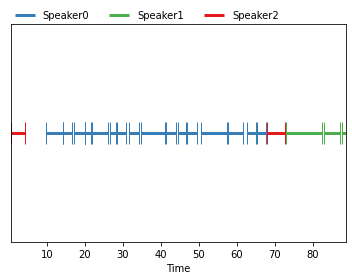

In [17]:
diarization

Pyannote does the job! As you can see, three speakers have been detected in our audio. They are represented on the sketch above in red, blue and green and we get the timestamps of each speaking time. Then, we know who speaks when!
As in the first episode, the idea would be to merge the timestamps of each speakers if they don't exceed a max_space value, to reduce the number of audio chunks and avoid memory problems. 

To do that, we first need to convert the result of diarization into manipulable data. This will be done thanks to *Timedelta* class, from *pandas* library. 

In [18]:
def convert_dia_results_to_timedelta(diarization_result, start):
    """
    Extract from diarization result the given speakers with their respective speaking times and transform them in pandas timedelta objects
    :param diarization_result: result of diarization
    :return: list with timedelta intervals and its respective speaker
    """
    
    segments = diarization_result.for_json()["content"]
    diarization_timestamps = []
    for sample in segments:

        new_seg = [pd.Timedelta(seconds = round(sample["segment"]["start"] + start, 2)), pd.Timedelta(seconds = round(sample["segment"]["end"] + start, 2)), sample["label"]]
        # start and end = speaking duration
        # label = who is speaking
        diarization_timestamps.append(new_seg)

    return diarization_timestamps

Then, we merge the segments that follow each other and mention the same speaker, as long as the time interval does not exceed the max_space value.

In [19]:
def merge_speaker_times(diarization_timestamps, max_space, srt_token = False):
    """
    Merge near times for each detected speaker. (Same speaker during 1-2s and 3-4s -> Same speaker during 1-4s)
    :param diarization_timestamps: diarization list
    :param srt_token: Enable/Disable generate srt file (choice fixed by user)
    :return: list
    """
    if not srt_token:
        threshold = pd.Timedelta(seconds=max_space/1000)

        index = 0
        length = len(diarization_timestamps) - 1

        while index < length:
            if diarization_timestamps[index + 1][2] == diarization_timestamps[index][2] and diarization_timestamps[index + 1][0] - threshold <= diarization_timestamps[index][0]:
                diarization_timestamps[index][1] = diarization_timestamps[index + 1][1]
                del diarization_timestamps[index + 1]
                length -= 1
            else:
                index += 1
    return diarization_timestamps

Finally, we try to extand the timestamps to avoid word cutting. Imagine we have a segment `[00:01:20 --> 00:01:25]`, followed by `[00:01:27 --> 00:01:30]`.

Maybe diarizations is not working fine and there is some sound missing in the segments (means missing sound is between `00:01:25` and `00:01:27`). Solution consists in fixing the end of the first segment and the start of the second one to `00:01:26`, the middle of these values.

In [20]:
def extanding_timestamps(new_diarization_timestamps):
    """
    Extand timestamps between each diarization if possible, so we avoid word cutting
    :param new_diarization_timestamps: list
    :return: list with merged times
    """
    for i in range(1, len(new_diarization_timestamps)):
        if new_diarization_timestamps[i][0] - new_diarization_timestamps[i - 1][1] <= timedelta(milliseconds=3000) and new_diarization_timestamps[i][0] - new_diarization_timestamps[i - 1][1] >= timedelta(milliseconds=100):
            middle = (new_diarization_timestamps[i][0] - new_diarization_timestamps[i - 1][1]) / 2
            new_diarization_timestamps[i][0] -= middle
            new_diarization_timestamps[i - 1][1] += middle

    # Convert list elements so we have a milliseconds format
    for elt in new_diarization_timestamps:
        elt[0] = elt[0].total_seconds() * 1000
        elt[1] = elt[1].total_seconds() * 1000

    return new_diarization_timestamps

Let's apply these three functions to the result of our diarization!

In [21]:
if len(diarization) > 0:
    diarization_timestamps = convert_dia_results_to_timedelta(diarization, start=0)
    diarization_timestamps = merge_speaker_times(diarization_timestamps, max_space=45000)
    diarization_timestamps = extanding_timestamps(diarization_timestamps)

Let's have a look to our new timestamps : 

In [22]:
print(diarization_timestamps)

[[500.0, 4380.0, 'Speaker2'], [9860.0, 57620.0, 'Speaker0'], [57620.0, 67870.0, 'Speaker0'], [67870.0, 72820.0, 'Speaker2'], [72820.0, 88670.0, 'Speaker1']]


As you can see, we went from 22 timestamps to 5! This means that we will have less audio chunks to create, and we won't have any memory problems since none of them last longer than 45 seconds.

Now that we have merged the timestamps, we can transcribe our audio! You can play the audio file with the following code :

In [23]:
Audio("sounds/" + filename, autoplay=False)

Then, we are going to create a timestamped transcript by converting the considered timestamps in displayed timedelta objects.

In [24]:
# Need to convert in a list of lists if we don't have one. (only the case with very short audio files)
if not isinstance(diarization_timestamps[0], list):  
    diarization_timestamps = [diarization_timestamps]

# Create a list where transcript will be saved. It will be used after. 
save_result_list = []

# Transcript audio
for index, elt in enumerate(diarization_timestamps):
    sub_start = elt[0]
    sub_end = elt[1]
    
    temp_transcript = transcribe_audio_part(filename, stt_model, stt_tokenizer, conversation_audio, sub_start, sub_end, index)
    
    temp_timestamps = str(timedelta(milliseconds=sub_start)).split(".")[0] + " --> " + \
                              str(timedelta(milliseconds=sub_end)).split(".")[0] + "\n"
    
    # Create a string with speaker's name and the transcript
    complete_temp_transcript = elt[2] + ": " + temp_transcript
    
    # Display timestamps and the respective string
    print(temp_timestamps)
    print(complete_temp_transcript+ "\n\n")
    
    # Add result to the list, so we can use it after
    save_result_list.append([temp_timestamps, int(elt[2][-1]), elt[2], " : " + temp_transcript, int(sub_start / 1000)])

0:00:00 --> 0:00:04

Speaker2: oh i propose that we stat with the presentation at nesjerson


0:00:09 --> 0:00:57

Speaker0: i' etso the previous movies that we've done this year were learns of arabia puapoclips now and emedaus which were all historical serious dramatic and somewhat actione movies so for this month i'd propose doing something different preferably something set in the presence amm something may be dramatic but slightly less serious so what i'd propose is actually a thriller o mystery and while these days people are so jated by general movies that they tend not to be surprised by the endings and mysteries some movies in the nindies did actually have twist that people came out saying never saw that coming i didn't know that that was going to happen and so what i'm going to doce present you tro those movies and before anyone says that well if you know how the moviands you're not goine on to seet again


0:00:57 --> 0:01:07

Speaker0: that's not necessarily the case becs a 

Result is pretty good. The interlocutors have been well distinguished. However, the transcript is not as good as the one obtained with the audio from the first tutorial. But this is due to the speed of the dialogue, which is faster this time, the quality of the audio recording, and the accent of the speakers.

Also, it is important to remember that our audio is only one minute long, which is hard to analyse because each speaker does not have so much time to speak. The error rate of diarization is therefore more important. It should work better if the file is longer.

### E - Rename speakers

Of course, it would be interesting to have the possibility to rename the detected speakers in the audio file. Indeed, having Speaker0, Speaker1, ... is fine but it could be so much better! Guess what? We are going to do this! 

First, create a list where you add each speaker with his 'ID'. Then, it is important to sort the list because we want the smallest ID at the beginning of our list, so we don't exchange names between speakers. 

In [25]:
if number_of_speakers > 0:
    # Save the Speaker Name and its ID in a list, example : [1, 'Speaker1']
    list_of_speakers = []
    for elt in save_result_list:        
        if [elt[1], elt[2]] not in list_of_speakers:
            list_of_speakers.append([elt[1], elt[2]])

    # Sort (by ID) so we do not have an unsorted case like [1, 'Speaker1'], [0, 'Speaker0']]
    list_of_speakers.sort()  
    
    print(list_of_speakers)

[[0, 'Speaker0'], [1, 'Speaker1'], [2, 'Speaker2']]


As you can see, we have the three detected speakers with their respective names and IDs.

Now, let's rename the names of our speakers as *'Agnes'* and *'Mirek'* and *'French speaker'* to follow their conversation easily!

In [26]:
# Do not change the name_index value. It indicates the index of the name in the list_of_speakers list.
name_index = 1

# Change names
list_of_speakers[0][name_index] = "Agnes"
list_of_speakers[1][name_index] = "Mirek"
list_of_speakers[2][name_index] = "French speaker"

Everything is ready! We just have to apply the changes to our initial save_result list, and print the transcript again to see the changes!

In [27]:
for elt in save_result_list:
    elt[2] = list_of_speakers[elt[1]][1]
    print(elt[0], elt[2] + elt[3] + "\n", sep='')

0:00:00 --> 0:00:04
French speaker : oh i propose that we stat with the presentation at nesjerson

0:00:09 --> 0:00:57
Agnes : i' etso the previous movies that we've done this year were learns of arabia puapoclips now and emedaus which were all historical serious dramatic and somewhat actione movies so for this month i'd propose doing something different preferably something set in the presence amm something may be dramatic but slightly less serious so what i'd propose is actually a thriller o mystery and while these days people are so jated by general movies that they tend not to be surprised by the endings and mysteries some movies in the nindies did actually have twist that people came out saying never saw that coming i didn't know that that was going to happen and so what i'm going to doce present you tro those movies and before anyone says that well if you know how the moviands you're not goine on to seet again

0:00:57 --> 0:01:07
Agnes : that's not necessarily the case becs a lo

> Congratulations, you now have the transcript of a conversation between your interlocutors with their speaking times! 

# Step 3 : Create a SRT transcript (subtitles for videos)

We just saw that we can create a timestamped transcript instead of creating a simple transcript.txt. That could help us to create subtitles for videos for your viewers or even deaf persons! 

Idea is very simple here, process is the same as before. We just have to shorten the timestamps, so the transcript is synchronized with the video. 

Indeed, a 30s timestamp will be accompanied by a lot of text as shown in the figure on the left below, which spoils the visual effect of the subtitles synchronization. We want to have 10s maximum timestamps, which means short texts, which each will move automatically to the next one, like the figure on the right below.

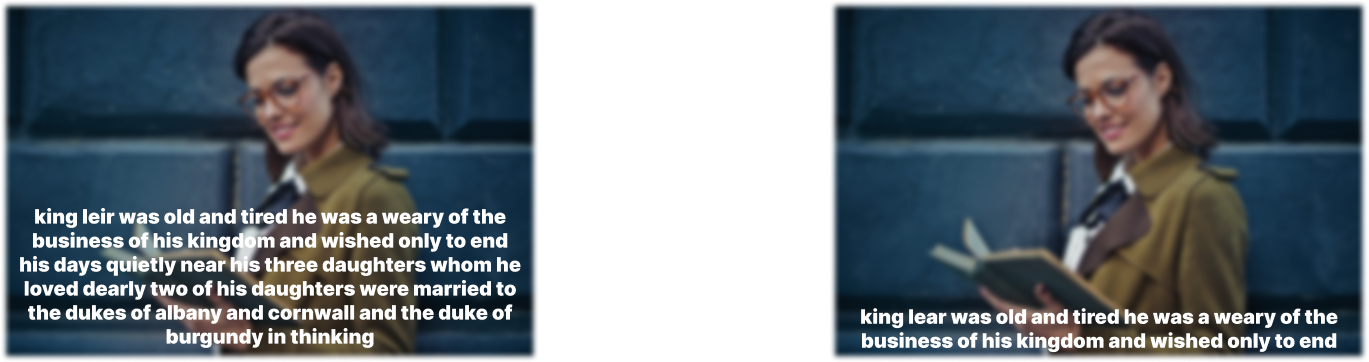


Illustration of the too large timestamps issue. *Photo by [Andrea Piacquadio, Pexels](https://www.pexels.com/photo/woman-in-brown-suede-peacoat-reading-a-book-762080/)*
     
To do that, we just have to modify the minimum and maximum length (minimum and max_space) values!

In [28]:
# Tiny time intervals if we want a short text
min_space = 1000  # 1 sec
max_space = 8000  # 8 secs

Once this is done, we just have to set the srt_token to True, to adapt the code and create short intervals instead of the largest ones as possible. Then, you can either choose the silence detection or the diarization method. SRT transcription works with both, but it makes more sense if you opt for the silence detection, as it is faster to process and does not give you the information about who is speaking when, thing that we do not need because of the video.

### A - Trim an audio

Let's do this with the audio file from the first tutorial! (but only on the first minute so we don't get a massive output)

In [29]:
# Load audio file and trim it from 0s to 58s
start = 0
end = 60

my_audio = AudioSegment.from_file("../basics/sounds/thechildrensshakespeare_04_nesbit.mp3")
my_audio = my_audio[start*1000:end*1000]  # Works in milliseconds (*1000)

srt_token = True

### B - Generate .srt transcript

In [30]:
# Silences treatment (detection, middle values, and merge)
srt_silence_list = detect_silences(my_audio)
srt_new_silence_list=get_middle_values(srt_silence_list)
srt_new_silence_list2 = silences_distribution(srt_new_silence_list, min_space, max_space, start, end, srt_token)

# Transcribe audio and obtain subtitles
srt_transcript = ""
for i in range(0, len(srt_new_silence_list2) - 1):
    sub_start = srt_new_silence_list2[i]
    sub_end = srt_new_silence_list2[i + 1]

    transcript = transcribe_audio_part(filename, stt_model, stt_tokenizer, my_audio, sub_start, sub_end, i) + " "
    
    srt_transcript += str(i) + "\n" + str(timedelta(milliseconds=sub_start)).split(".")[0] + " --> " + str(timedelta(milliseconds=sub_end)).split(".")[0] + "\n" + transcript + "\n\n"

*⚠️ Here again, some warnings due to the libraries we use can appear, don't worry about them.*

Are you ready? Let's take a look at our subtitles!

In [31]:
print(srt_transcript)

0
0:00:00 --> 0:00:08
chapter four of the children shakespeare this is a librovox recording all li bravax recordings are in the public domain 

1
0:00:08 --> 0:00:13
for more information or to volunteer please visit librivax dod orge 

2
0:00:13 --> 0:00:16
recording by elizabeth clatt 

3
0:00:16 --> 0:00:20
the children shakespeare by edith nespit 

4
0:00:20 --> 0:00:22
chapter four 

5
0:00:22 --> 0:00:24
kingleer 

6
0:00:24 --> 0:00:32
king lear was old and tired he was a weary of the business of his kingdom and wished only to end his days q 

7
0:00:32 --> 0:00:35
ietly near his three daughters whom he loved dearly 

8
0:00:35 --> 0:00:43
two of his daughters were married to the dukes of albany and cornwall and the duke of burgundy in thinking of france were both staying at leir's court 

9
0:00:43 --> 0:00:48
as suitors for the hand of cordelia his youngest daughter 

10
0:00:48 --> 0:00:54
leir called his three daughters together and told them that he proposed to divide his ki

Excellent! You now have your timestamped transcript. All transcripts are synchronized with their time interval, and each of them is very short, which allows the transcript to be synchronized with a video. 

If you want to generate an `.srt` file, it is important to have the transcript numbers every time like above (before each timestamp). Of course, these numbers will not appear in the subtitles.

### C - Export timestamped transcript as .srt file

Now, you can export this timestamped transcript in a `.srt` file.

In [32]:
# Create a folder
dir_path = "saved_transcripts" 
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    
with open(dir_path + '/transcript.srt', 'w+') as f:
    f.write(srt_transcript)

Your transcript is now saved! Now, you are able to import this file on a compatible media player software and follow your video with your generated subtitles! Rather amazing, isn't it? 

## Conclusion

I hope you have enjoyed this tutorial!

You are now capable of creating a transcript with a speaker differentiation (diarization) and a timestamped transcript to generate video's subtitles!

You can check our **next tutorials** about speech to text to learn how to:

- Compare models and choose the best one
- Build a complete speech to text application with Streamlit to make your code interactive.